In [114]:
import pprint
from itertools import chain
import functools
import itertools
import random
from collections import defaultdict

from fuzzywuzzy import fuzz
from pymongo import MongoClient
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import scipy
from cycler import cycler
from IPython.display import display

from esc_identifier.distance import (
    # Frequence based distances
    ratio_distance,
    partial_ratio_distance,
    token_sort_distance,
    partial_token_sort_distance,
    token_set_distance,
    partial_token_set_distance,
    # Edit distances
    jaro_distance,
    jaro_winkler_distance,
    levenshtein,
    levenshtein_sort,
    damerau_levenshtein,
)
from esc_identifier.cluster import dbscan, get_clusters
# from esc_identifier.utils import prepare_string
from esc_identifier.utils.string import (
    normalize_affiliation, normalize_human_name)
from jupyter_utils import log_progress

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
MONGO_URI = 'mongodb://localhost:27017/'

mongo_client = MongoClient(MONGO_URI)
kdd_db = mongo_client.kdd2013
author_collection = kdd_db.author

In [41]:
#TODO: ignore samples with only one variation
def generate_test_data(dataset, size, sample_length, max_variations):
    X_test, y_test = [], []

    for _ in range(size):
        data_sample = random.sample(dataset, sample_length)
        clusters = [random.sample(item,
                                  random.randint(1,
                                                 min(len(item),
                                                     max_variations)
                                                )
                                 )
                    for item
                    in data_sample]

        y_true = list(itertools.chain.from_iterable([i] * len(cluster) for i, cluster in enumerate(clusters)))
        
        X_test.append(list(itertools.chain.from_iterable(clusters)))
        y_test.append(y_true)
    
    return X_test, y_test

In [4]:
author_cache = list(author_collection.find())
names_data = [author['names'] for author in author_cache]
affiliations_data = [author['affiliations'] for author in author_cache]

In [5]:
test_data_size = 100
sample_size = 5
max_variations = 5
random_seed = 42

random.seed(random_seed)

In [6]:
X_test_names, y_test_names = generate_test_data(
    dataset=names_data,
    size=test_data_size,
    sample_length=sample_size,
    max_variations=max_variations)

X_test_affiliations, y_test_affiliations = generate_test_data(
    dataset=affiliations_data,
    size=test_data_size,
    sample_length=sample_size,
    max_variations=max_variations)

In [146]:
# pd.set_option('precision', 5)

distance_functions = [
    (token_set_distance, 'Token set ratio'),
    (token_sort_distance, 'Token sort ratio'),
    (levenshtein, 'Levenshtein'),
    (ratio_distance, 'Ratio'),
    (partial_ratio_distance, 'Partial ratio'),
    (jaro_distance, 'Jaro'),
    (jaro_winkler_distance, 'Jaro-Winkler'),
    (damerau_levenshtein, 'Damerau-Levenshtein'),
# 
#     (partial_token_sort_distance, 'Partial token sort ratio'),
#     (partial_token_set_distance, 'Partial token set ratio'),
#     (levenshtein_sort, 'Levenshtein sort'),
#     (most_freq_k_sdf_normalized, 'MostFreqKSDF')
]

def lalala(X_test, y_test, distance_function, eps):
    import warnings
    warnings.filterwarnings('ignore')

    # Other variants: min, np.median, scipy.stats.hmean
    average = np.mean

    precision, recall, f1 = [], [], []

    for X, y_true in zip(X_test, y_test):
        clusters_pred = get_clusters(X, distance_function=distance_function, eps=eps)

        y_pred = [None] * len(y_true)
        for cluster_idx, cluster in enumerate(clusters_pred):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx

        _precision, _recall, _f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        precision.append(_precision)
        recall.append(_recall)
        f1.append(_f1)

    return (
        average(precision),
        average(recall),
        average(f1)
    )

eps_range = np.linspace(0.01, 0.9, 100)

datasets = [
    (X_test_names, y_test_names, 'names'),
    (X_test_affiliations, y_test_affiliations, 'affiliations')
]

datasets_results = defaultdict(dict)

for X_test, y_test, dataset_name in datasets:
    df = pd.DataFrame(columns=['eps', 'precision', 'recall', 'f1'])
    for (distance_function, distance_function_name) in distance_functions:
        #TODO: rename
        distance_function_metrics = pd.DataFrame(columns=['eps', 'precision', 'recall', 'f1'])

        for i, eps in log_progress(eps_range,
                                   name=f'[{dataset_name}] {distance_function_name}'):
            precision, recall, f1 = lalala(X_test, y_test, distance_function, eps)

            distance_function_metrics.loc[i] = {
                'eps': eps,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }

        datasets_results[distance_function_name][dataset_name] = distance_function_metrics

        df = df.append(
            pd.Series(distance_function_metrics.loc[np.argmax(distance_function_metrics.f1)],
                      name=distance_function_name)
        )
    print(dataset_name)
    display(df.sort_values('f1', ascending=False))

names


,eps,precision,recall,f1
Token set ratio,0.297677,0.990000,0.992000,0.990667
Partial ratio,0.360606,0.938667,0.947000,0.940603
Ratio,0.468485,0.938278,0.944000,0.939232
Token sort ratio,0.450505,0.927100,0.931333,0.927581
Levenshtein,0.531414,0.891325,0.891647,0.888800
Damerau-Levenshtein,0.531414,0.891325,0.891647,0.888800
Jaro-Winkler,0.270707,0.847690,0.838548,0.839451
Jaro,0.288687,0.846690,0.837048,0.838295


affiliations


,eps,precision,recall,f1
Token set ratio,0.414545,0.860425,0.865333,0.856641
Partial ratio,0.378586,0.772847,0.770303,0.760785
Token sort ratio,0.513434,0.619779,0.610723,0.599116
Ratio,0.504444,0.605887,0.593082,0.585463
Levenshtein,0.693232,0.588050,0.593886,0.570199
Damerau-Levenshtein,0.693232,0.582845,0.591219,0.566832
Jaro,0.324646,0.543482,0.522842,0.513312
Jaro-Winkler,0.324646,0.543482,0.522842,0.513312


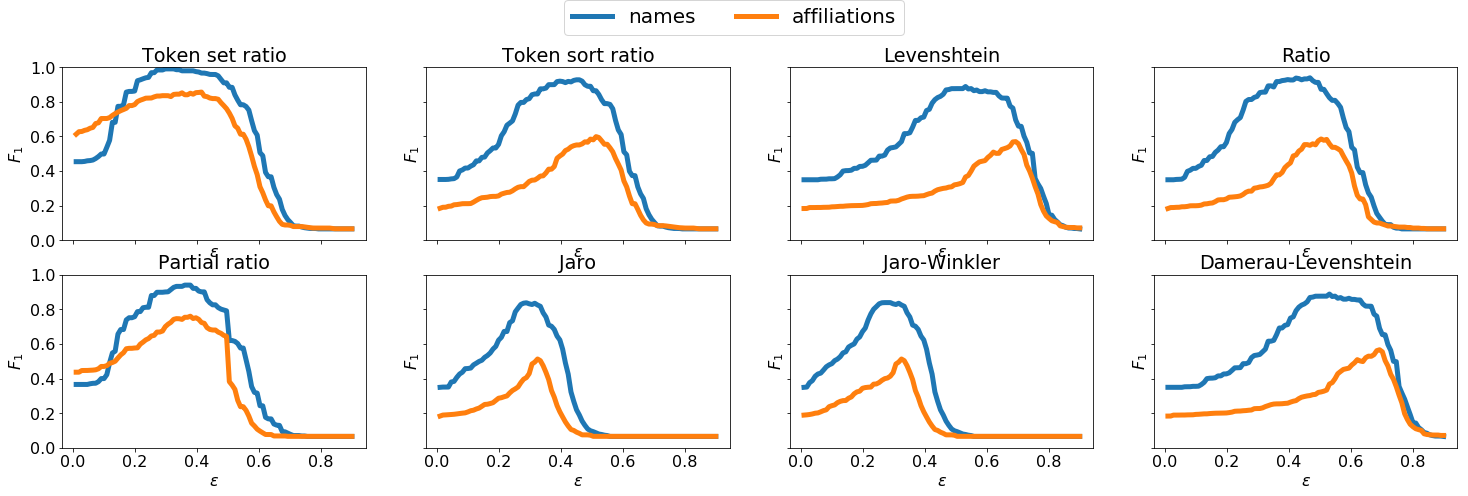

In [161]:
plt.rc('font', size=16) 
# plt.rc('axes',
#        prop_cycle=cycler('linestyle', ['-.', '--', '-']))

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(25, 7))

for (distance_function_name, datasets), axis in zip(datasets_results.items(), axes.ravel()):
    axis.set_title(distance_function_name)
    axis.set_ylim([0, 1])   
    axis.set_xlabel(r'$\varepsilon$')
    axis.set_ylabel('$F_1$')

    names_f1, = axis.plot(eps_range, datasets['names'].f1, linewidth=5)
    affiliations_f1, = axis.plot(eps_range, datasets['affiliations'].f1, linewidth=5)

fig.legend(
    (names_f1, affiliations_f1),
    labels=('names', 'affiliations'),
    ncol=2,
    loc='upper center',
    borderaxespad=0.,
    fontsize=20
);

In [92]:
import warnings
warnings.filterwarnings('ignore')

distance_functions = [
    (token_set_distance, 'Token set ratio'),
    (token_sort_distance, 'Token sort ratio'),
    (levenshtein, 'Levenshtein'),
    (ratio_distance, 'Ratio'),
    (partial_ratio_distance, 'Partial ratio'),
    (jaro_distance, 'Jaro'),
    (jaro_winkler_distance, 'Jaro-Winkler'),
    (damerau_levenshtein, 'Damerau-Levenshtein'),
# 
#     (partial_token_sort_distance, 'Partial token sort ratio'),
#     (partial_token_set_distance, 'Partial token set ratio'),
#     (levenshtein_sort, 'Levenshtein sort'),
#     (most_freq_k_sdf_normalized, 'MostFreqKSDF')
]

# Other variants: min, np.median, scipy.stats.hmean
average = np.mean

eps_range = np.linspace(0.01, 0.9, 50)


df = pd.DataFrame(columns=['eps', 'precision', 'recall', 'f1'])
precision_recall_f1 = {}

X_test, y_test = X_test_names, y_test_names
# X_test, y_test = X_test_affiliations, y_test_affiliations

for (distance_function, distance_function_name) in distance_functions:
    #TODO: rename
    d = pd.DataFrame(columns=['eps', 'precision', 'recall', 'f1'])
    for i, eps in log_progress(eps_range, name=distance_function_name):
        precision, recall, f1 = [], [], []
        for X, y_true in zip(X_test, y_test):
            clusters_pred = get_clusters(X, distance_function=distance_function, eps=eps)

            y_pred = [None] * len(y_true)
            for cluster_idx, cluster in enumerate(clusters_pred):
                for sample_idx in cluster:
                    y_pred[sample_idx] = cluster_idx

            _precision, _recall, _f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            precision.append(_precision)
            recall.append(_recall)
            f1.append(_f1)

        d.loc[i] = {
            'eps': eps,
            'precision': average(precision),
            'recall': average(recall),
            'f1': average(f1)
        }
#     display(d)

    precision_recall_f1[distance_function_name] = d

    df = df.append(
        pd.Series(d.loc[np.argmax(d.f1)],
                  name=distance_function_name)
    )

df.sort_values('f1', ascending=False)

,eps,precision,recall,f1
Token set ratio,0.300612,0.990000,0.992000,0.990667
Partial ratio,0.373265,0.938667,0.947000,0.940603
Ratio,0.464082,0.938278,0.944000,0.939232
Token sort ratio,0.445918,0.924433,0.927167,0.924092
Levenshtein,0.554898,0.877135,0.882504,0.876752
Damerau-Levenshtein,0.554898,0.877135,0.882504,0.876752
Jaro-Winkler,0.264286,0.847690,0.838548,0.839451
Jaro,0.282449,0.846690,0.837048,0.838295


In [93]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

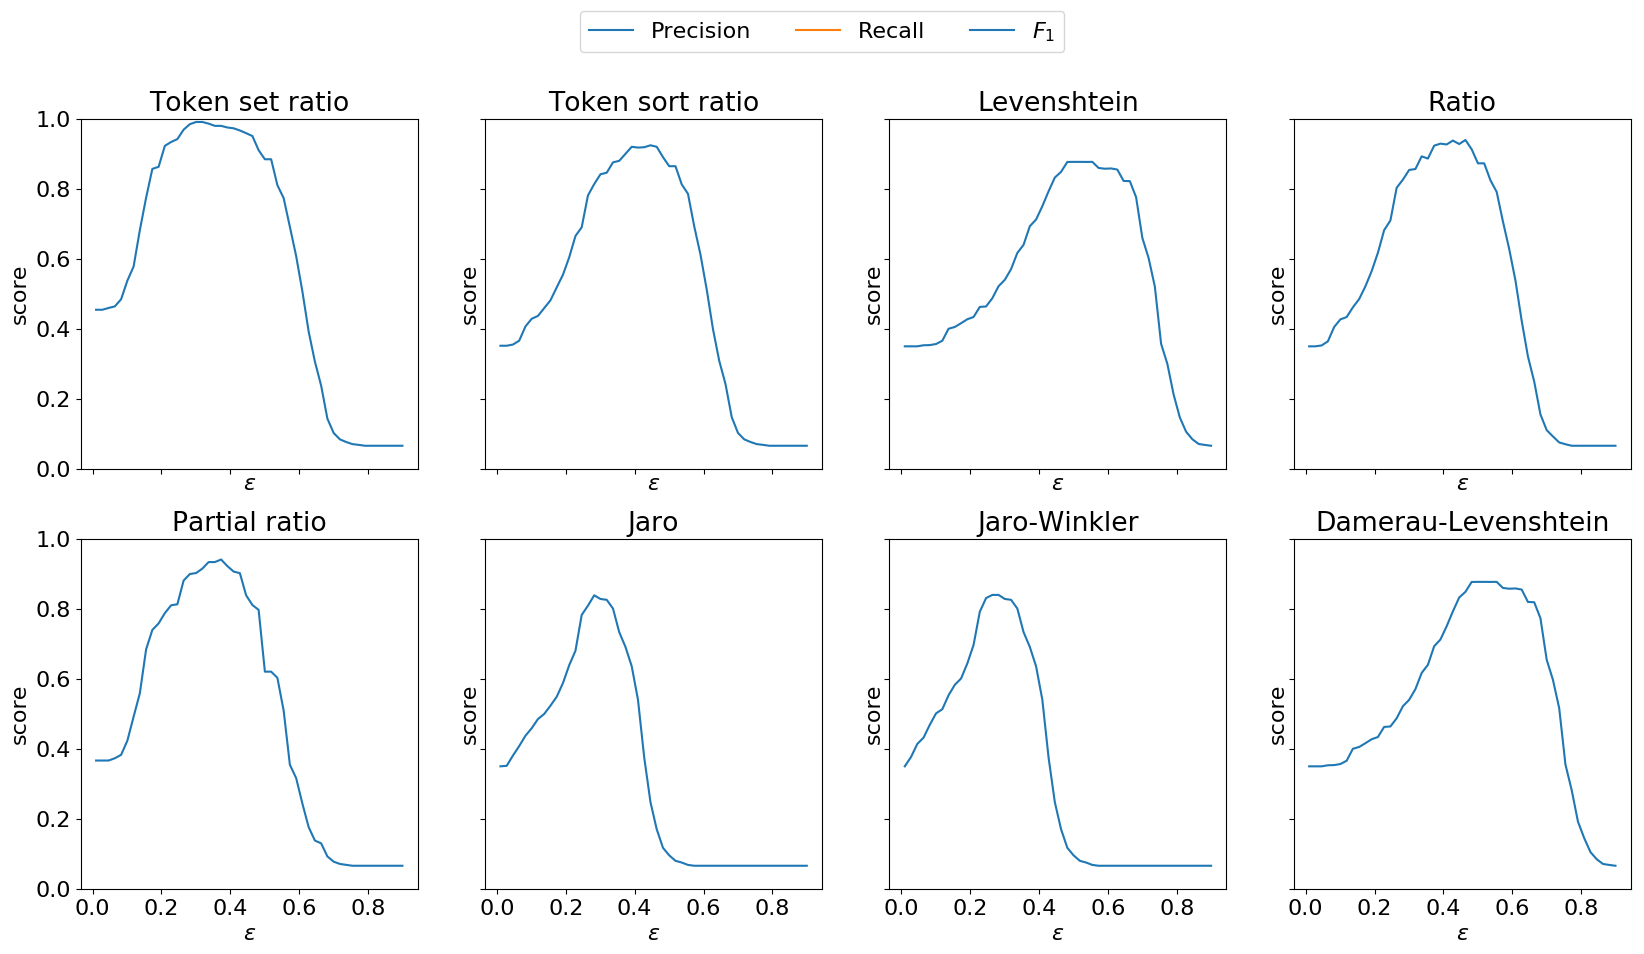

In [98]:
plt.rc('font', size=16) 
# plt.rc('axes',
#        prop_cycle=cycler('linestyle', ['-.', '--', '-']))

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 10))

for (distance_function_name, d), axis in zip(precision_recall_f1.items(), axes.ravel()):
    axis.set_title(distance_function_name)
    axis.set_ylim([0, 1])   
    axis.set_xlabel(r'$\varepsilon$')
    axis.set_ylabel('score')

#     precision, = axis.plot(eps_range, d.precision, markevery=10)
#     recall, = axis.plot(eps_range, d.recall, markevery=2)
    f1, = axis.plot(eps_range, d.f1, markevery=2)

fig.legend(
    (precision, recall, f1),
    labels=('Precision', 'Recall', r'$F_1$'),
    ncol=3,
    loc='upper center'
);

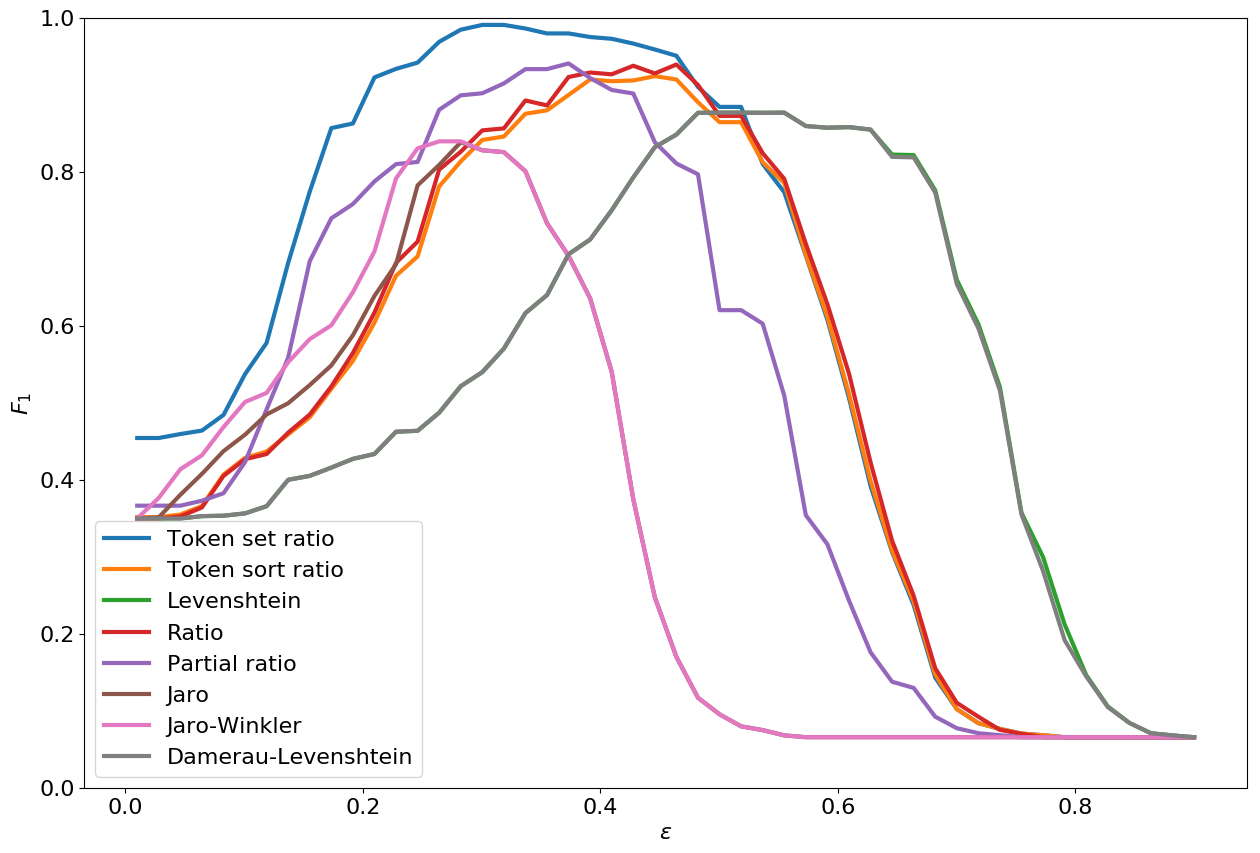

In [95]:
plt.rc('font', size=16) 

plt.figure(figsize=(15, 10))

for distance_function_name, d in precision_recall_f1.items():
    plt.plot(eps_range, d.f1, label=distance_function_name, linewidth=3.0)

plt.ylim([0, 1])

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$F_1$')

plt.legend(loc='best', prop={'size': 16})
plt.show()

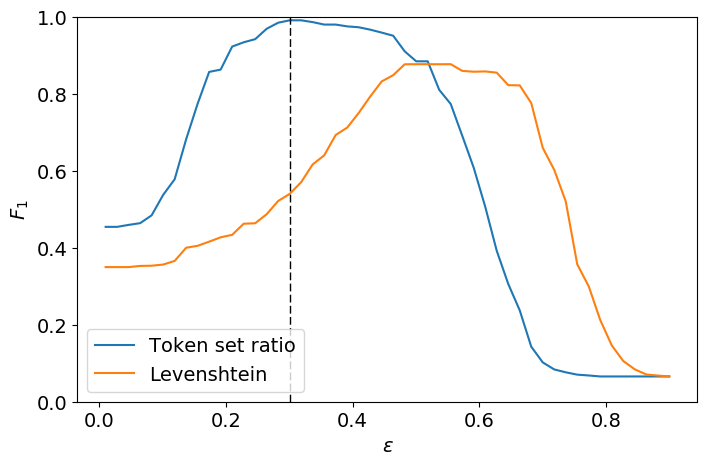

In [97]:
plt.rc('font', size=14) 
# plt.rc('lines', color='k')
# plt.rc('axes',
#        prop_cycle=cycler('marker', ['', '>']))

plt.figure(figsize=(8, 5))

# for distance_function_name, (precision, recall, fbeta) in precision_recall_fbeta.items():
f = 'Token set ratio'
plt.plot(eps_range,
         precision_recall_f1[f].f1,
         label=f)

f = 'Levenshtein'
plt.plot(eps_range,
         precision_recall_f1[f].f1,
         label=f)

f1_optimal = df.sort_values('f1', ascending=False)[:1]['eps']
plt.plot([f1_optimal, f1_optimal], [0, 1], 'k--', linewidth=1.0)

plt.ylim([0, 1])

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$F_1$')

plt.legend(loc='best', prop={'size': 14})
plt.show()